In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import statsmodels.api as sm
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
import pickle
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
from tensorflow.keras import models, layers, utils, backend as K
import matplotlib.pyplot as plt
import shap
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from lime import lime_tabular
from sklearn.model_selection import GridSearchCV

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [28]:
matches_final = pd.read_csv('../dataset/matches_r2.csv')

In [29]:
matches_final.shape

(15689, 10)

In [30]:
matches_final.head()

,result,offence_box_adv,offence_GK_adv,defence_box_adv,defence_GK_adv,offence_pass_adv,offence_move_adv,defence_pass_adv,defence_move_adv,offence_misc_adv
0,win,0.998805,0.909864,1.188616,1.213864,1.070371,1.055491,1.129365,0.939151,1.111281
1,win,0.953050,0.916029,0.958295,1.124031,0.857672,1.019841,1.031083,0.659104,1.009207
2,tie,0.850986,0.949814,0.985615,1.219231,0.815437,1.097571,0.919066,0.803688,0.880322
3,lose,0.838592,0.762483,1.185132,1.311599,0.972593,1.392121,1.130798,0.979385,1.015217
4,win,0.882419,0.853064,0.897846,1.156257,0.862961,1.067194,0.987768,0.912083,0.918860


In [31]:
matches_final.dtypes

result               object
offence_box_adv     float64
offence_GK_adv      float64
defence_box_adv     float64
defence_GK_adv      float64
offence_pass_adv    float64
offence_move_adv    float64
defence_pass_adv    float64
defence_move_adv    float64
offence_misc_adv    float64
dtype: object

In [32]:
matches_final.isna().sum()

result              0
offence_box_adv     0
offence_GK_adv      0
defence_box_adv     0
defence_GK_adv      0
offence_pass_adv    0
offence_move_adv    0
defence_pass_adv    0
defence_move_adv    0
offence_misc_adv    0
dtype: int64

In [33]:
matches_final['result'].value_counts()

win     7140
lose    4634
tie     3915
Name: result, dtype: int64

In [34]:
matches_final.result = matches_final.result.astype('category')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(matches_final.drop(columns='result'), 
                                                    matches_final.result, test_size=0.25, 
                                                    random_state=47)

In [36]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(11766, 9) (3923, 9)
(11766,) (3923,)


In [44]:
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [45]:
y_train.value_counts()

lose    5357
tie     5357
win     5357
Name: result, dtype: int64

In [44]:
#scaler = MinMaxScaler()

In [45]:
#scaler.fit(X_train)
#X_train_transformed = scaler.transform(X_train)

#X_test_transformed = scaler.transform(X_test)

In [14]:
# Logistic Regression pipeline
lr_pipeline = Pipeline([('lr', LogisticRegression())])

# Random Forest pipeline
rf_pipeline = Pipeline([('rf', RandomForestClassifier())])

# K-Nearest Neighbors pipeline
knn_pipeline = Pipeline([('knn', KNeighborsClassifier())])

# List of pipelines
pipelines = [lr_pipeline, rf_pipeline, knn_pipeline]

In [15]:
def metrics_display(model):
    '''display model performence metrics'''
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    fig, ax = plt.subplots(figsize=(3, 3))  
    disp.plot(ax=ax)  
    plt.show()  

In [46]:
for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'{model_name} Accuracy: {accuracy:.2f}')

LogisticRegression Accuracy: 0.48
RandomForestClassifier Accuracy: 0.48
KNeighborsClassifier Accuracy: 0.41


              precision    recall  f1-score   support

        lose       0.44      0.59      0.51      1162
         tie       0.28      0.20      0.23       978
         win       0.60      0.57      0.59      1783

    accuracy                           0.48      3923
   macro avg       0.44      0.45      0.44      3923
weighted avg       0.48      0.48      0.47      3923



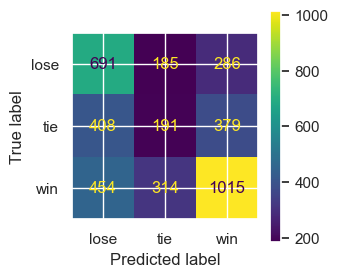

In [47]:
metrics_display(LogisticRegression())

In [49]:
param_grid = {
    'C': [0.1, 1.0, 10.0],                # Inverse of regularization strength
    'penalty': ['l1', 'l2'],               # Regularization penalty ('l1' for L1 regularization, 'l2' for L2 regularization)
    'solver': ['liblinear', 'saga']        # Algorithm to use in the optimization problem
}
# Create GridSearchCV with the Logistic Regression classifier and parameter grid
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=5)

# Fit the GridSearchCV on your training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score from the GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.4567239168451399


              precision    recall  f1-score   support

        lose       0.44      0.60      0.51      1162
         tie       0.28      0.18      0.22       978
         win       0.60      0.58      0.59      1783

    accuracy                           0.48      3923
   macro avg       0.44      0.45      0.44      3923
weighted avg       0.47      0.48      0.47      3923



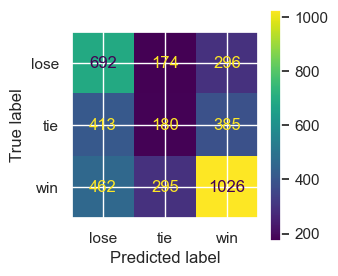

In [50]:
logistic = LogisticRegression(C=0.1, penalty= 'l2', solver='saga')
metrics_display(logistic)